# Natural Language Processing In Practice Tutorial By Neuraldemy

This tutorial is part of Neuraldemy's in depth tutorial on NLP. This notebook contains discussion regarding how we can solve various NLP tasks using the concepts we learned in the theory. 
___ 

**Author:** Amritesh Kumar, Neuraldemy  
**Course:** Natural Language Processing  
**Notebook No:** 03 
**Website:** https://neuraldemy.com/  
___

Readers are expected to have gone through the theory discussed in our free NLP tutorial and Notebook No 01 & 02 [https://github.com/kelixirr/Neuraldemy/blob/main/ML%20Tutorials/tokenization-text-processing-in-nlp.ipynb] 

## Forecasting Problems Using Recurrent Neural Nets

Jena Climate is weather timeseries dataset recorded at the Weather Station of the Max Planck Institute for Biogeochemistry in Jena, Germany.This dataset is made up of 14 different quantities (such air temperature, atmospheric pressure, humidity, wind direction, and so on) were recorded every 10 minutes, over several years. This dataset covers data from January 1st 2009 to December 31st 2016. In this tutorial, we are going to use this dataset to build a model that takes as input some data from the recent past (a few days’ worth of data points) and predicts the air temperature 24 hours in the future.

In [55]:
import tensorflow as tf
import numpy as np
import pandas as pd

df = pd.read_csv("/kaggle/input/jena-climate/jena_climate_2009_2016.csv")
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


In [56]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB


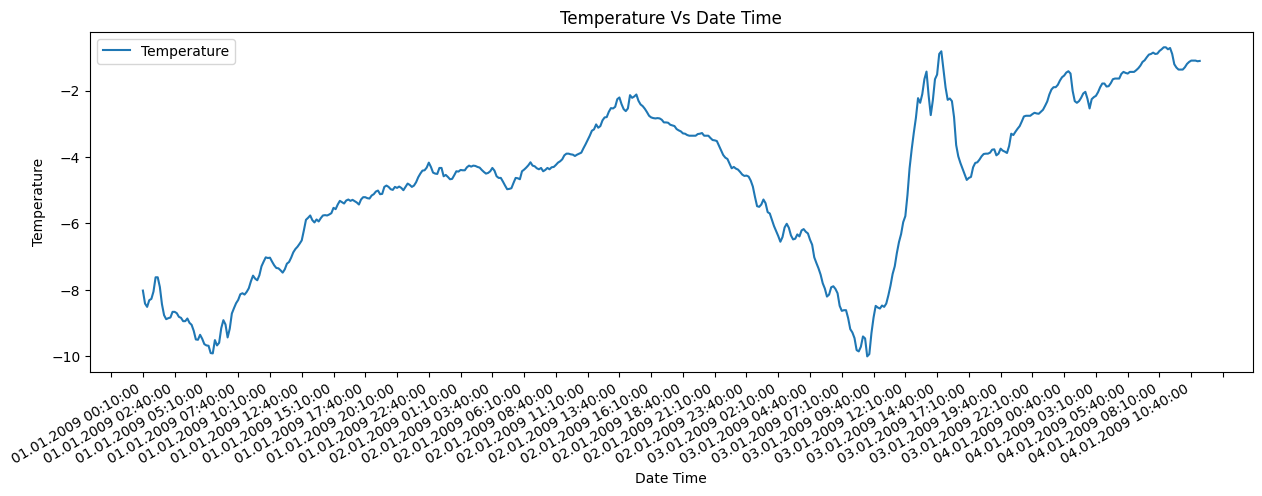

In [57]:
import matplotlib.pyplot as plt
plt.figure(figsize=(15, 5))
plt.plot(df["Date Time"][:500], df["T (degC)"][:500], label = "Temperature")
plt.gca().xaxis.set_major_locator(plt.MaxNLocator(50))
plt.gcf().autofmt_xdate()
plt.xlabel("Date Time")
plt.ylabel("Temperature")
plt.title("Temperature Vs Date Time")
plt.legend()
plt.show()

In [59]:
float_data = df.drop(columns=['Date Time']).values

In [60]:
float_data

array([[ 9.9652e+02, -8.0200e+00,  2.6540e+02, ...,  1.0300e+00,
         1.7500e+00,  1.5230e+02],
       [ 9.9657e+02, -8.4100e+00,  2.6501e+02, ...,  7.2000e-01,
         1.5000e+00,  1.3610e+02],
       [ 9.9653e+02, -8.5100e+00,  2.6491e+02, ...,  1.9000e-01,
         6.3000e-01,  1.7160e+02],
       ...,
       [ 9.9982e+02, -3.1600e+00,  2.7001e+02, ...,  1.0800e+00,
         2.0000e+00,  2.1520e+02],
       [ 9.9981e+02, -4.2300e+00,  2.6894e+02, ...,  1.4900e+00,
         2.1600e+00,  2.2580e+02],
       [ 9.9982e+02, -4.8200e+00,  2.6836e+02, ...,  1.2300e+00,
         1.9600e+00,  1.8490e+02]])

In [61]:
len(float_data)

420551

In [62]:
# normalize the whole data based on training set only
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

Now we are going to write a function that will yield a tuple (samples, targets),where samples is one batch of input data and targets is the corresponding array of target temperatures. We are going to use data, lookback, delay, and steps. 

Lookback is how many timesteps back the input data should go. Delay is how many timesteps in the future the target should be. Step is period, in timesteps, at which you sample data. 

In [63]:
def generator(data, lookback, delay, min_index, max_index, step = 6, shuffle = False, batch_size = 128):
    
    if max_index is None:
        max_index = len(data) - delay - 1 # substract the future timesteps and - 1 due to indexing 
    
    i = min_index + lookback # initialize 
    
    while True:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size = batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
            
        samples = np.zeros((len(rows),
                            lookback // step,
                            data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1] 
        
        yield samples, targets   
    

In [64]:
lookback = 1440
step = 6
delay = 144
batch_size = 128

train_gen = generator(float_data, lookback=lookback, delay=delay, min_index=0, max_index=200000, shuffle=True, step=step,batch_size=batch_size)
val_gen = generator(float_data, lookback=lookback, delay=delay, min_index= 200001, max_index=300000, shuffle=True, step=step,batch_size=batch_size)
test_gen = generator(float_data, lookback=lookback, delay=delay, min_index= 300001, max_index=None, shuffle=True, step=step,batch_size=batch_size)

val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

We will now create a baseline model using GRU for the task.

In [65]:
import keras
from keras.models import Sequential
model = Sequential()
model.add(keras.layers.Input(shape = (lookback//step, float_data.shape[-1])))
model.add(keras.layers.GRU(32))
model.add(keras.layers.Dense(1))
model.compile(optimizer = keras.optimizers.RMSprop(), loss = "mae")
history = model.fit(train_gen, steps_per_epoch = 500, epochs = 20, validation_data = val_gen, validation_steps = val_steps)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 23ms/step - loss: 0.3377 - val_loss: 0.2717
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2891 - val_loss: 0.2707
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2833 - val_loss: 0.2698
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2787 - val_loss: 0.2675
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2727 - val_loss: 0.2667
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 22ms/step - loss: 0.2667 - val_loss: 0.2637
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 11s 23ms/step - loss: 0.2652 - val_loss: 0.2639
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - loss: 0.2601 - val_loss: 0.2665
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.2571 - val_loss: 0.2723
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 32ms/step - loss: 0.2550 - val_loss: 0.2676
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 13s 27ms/step - loss: 0.2493 - val_loss: 0.2780
Epoch 12/20
500/500 ━━━━━━━━━━

In [66]:
def plot_result(history):
    
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    epochs = range(1, len(loss) + 1)
    
    plt.plot(epochs, loss, label = "Training Loss")
    plt.plot(epochs, val_loss, label = "Validation Loss")
    plt.title("Training and Validation Loss")
    plt.legend()
    plt.show()

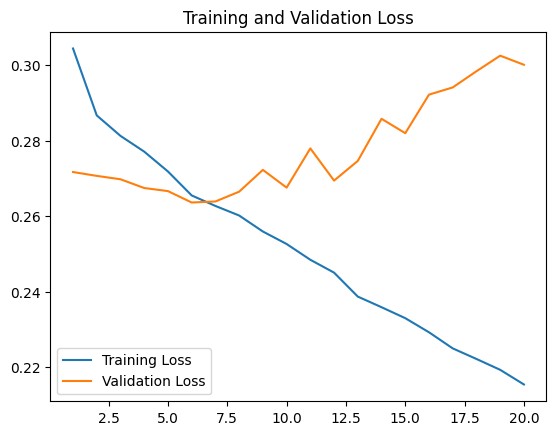

In [67]:
plot_result(history)

In [68]:
model2 = Sequential()
model2.add(keras.layers.Input(shape = (lookback//step, float_data.shape[-1])))
model2.add(keras.layers.GRU(32, return_sequences = True))
model2.add(keras.layers.GRU(32))
model2.add(keras.layers.Dense(16, activation = "relu"))
model2.add(keras.layers.Dense(1))
model2.compile(optimizer = keras.optimizers.RMSprop(), loss = "mae")
history2 = model2.fit(train_gen, steps_per_epoch = 500, epochs = 20, validation_data = val_gen, validation_steps = val_steps)

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 16s 29ms/step - loss: 0.3374 - val_loss: 0.2711
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 28ms/step - loss: 0.2840 - val_loss: 0.2656
Epoch 3/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.2779 - val_loss: 0.2711
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.2688 - val_loss: 0.2639
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.2645 - val_loss: 0.2682
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.2566 - val_loss: 0.2677
Epoch 7/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.2537 - val_loss: 0.2705
Epoch 8/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 15s 29ms/step - loss: 0.2470 - val_loss: 0.2741
Epoch 9/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.2427 - val_loss: 0.2758
Epoch 10/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.2370 - val_loss: 0.2804
Epoch 11/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 14s 29ms/step - loss: 0.2286 - val_loss: 0.2890
Epoch 12/20
500/500 ━━━━━━━━━━

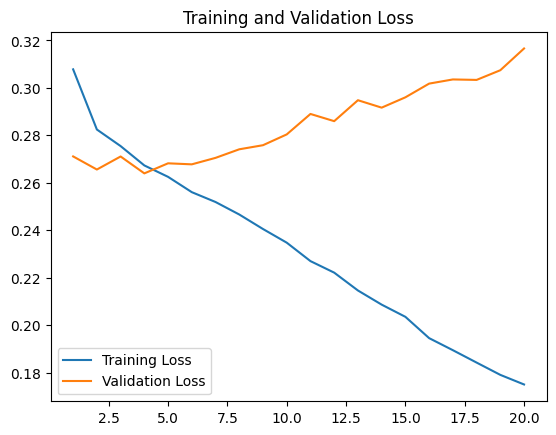

In [69]:
plot_result(history2)

In [70]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr_on_plateu = ReduceLROnPlateau(monitor = "val_loss", fraction = 0.5, patience = 2, verbose = 1)

model3 = Sequential()
model3.add(keras.layers.Input(shape = (lookback//step, float_data.shape[-1])))
model3.add(keras.layers.GRU(128, return_sequences = True))
model3.add(keras.layers.GRU(64, return_sequences = True))
model3.add(keras.layers.GRU(32))
model3.add(keras.layers.Dense(32, activation = "relu"))
model3.add(keras.layers.Dense(16, activation = "relu"))
model3.add(keras.layers.Dense(1))
model3.compile(optimizer = keras.optimizers.RMSprop(), loss = "mae")

history3 = model3.fit(train_gen, 
                      steps_per_epoch = 500, 
                      epochs = 20, 
                      validation_data = val_gen, 
                      validation_steps = val_steps, 
                      callbacks = [early_stopping, reduce_lr_on_plateu])

Epoch 1/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 27s 50ms/step - loss: 0.3410 - val_loss: 0.2712 - learning_rate: 0.0010
Epoch 2/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - loss: 0.2868 - val_loss: 0.2716 - learning_rate: 0.0010
Epoch 3/20
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2738
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - loss: 0.2738 - val_loss: 0.2721 - learning_rate: 0.0010
Epoch 4/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - loss: 0.2573 - val_loss: 0.2619 - learning_rate: 1.0000e-04
Epoch 5/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - loss: 0.2525 - val_loss: 0.2615 - learning_rate: 1.0000e-04
Epoch 6/20
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms/step - loss: 0.2509 - val_loss: 0.2617 - learning_rate: 1.0000e-04
Epoch 7/20
499/500 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - loss: 0.2476
Epoch 7: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
500/500 ━━━━━━━━━━━━━━━━━━━━ 24s 49ms

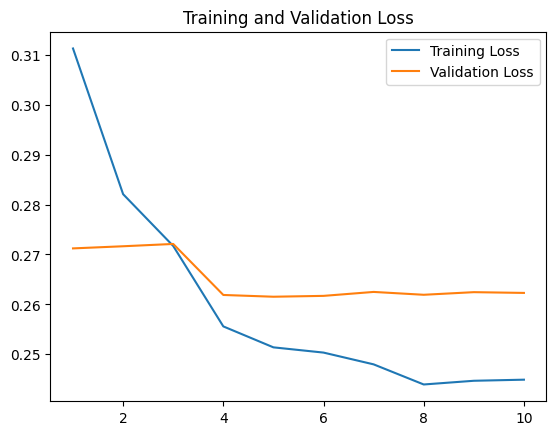

In [71]:
plot_result(history3)

We have improved our validation loss a little bit but we can further improve the model by tuning some hyperparameters such as dropout etc. Use dropouts carefully because in some cases it may result in loss: nan or gradient issues. 

Using Dropout: This is something I did not explain in previous notebook. Applying dropout directly to the inputs or outputs of recurrent layers in RNNs can be problematic. Because RNNs maintain state across time steps, applying dropout at each time step independently introduces noise that interferes with the network's ability to learn and propagate information over time. Instead of using a different dropout mask for each time step, the same dropout mask (with the same pattern of dropped units) is applied at every time step. This ensures consistency in the dropout pattern throughout the sequence and allows the network to effectively propagate error signals through time. For architectures like LSTM and GRU, which have inner recurrent activations (such as the forget gate, input gate, and output gate in LSTM), a temporally constant dropout mask should be applied specifically to these inner recurrent activations. This helps regularize the representations formed by these gates, preventing overfitting and improving the generalization ability of the network. In keras layers, dropouts arguments is used for inputs in a layer, and recurrent dropouts is for the recurrent connections.

In [72]:
test_loss = model3.evaluate(test_gen, steps=test_steps)

print("Test Loss:", test_loss)

930/930 ━━━━━━━━━━━━━━━━━━━━ 12s 13ms/step - loss: 0.2797
Test Loss: 0.2794659435749054


In [73]:
early_stopping.best

0.26153281331062317

This is our best loss at which our model weights were saved. Please note, since we normalized our data, you can convert the mae values into temperature using std and mean, compare the difference. 